In [1]:
import pandas as pd
import json
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

pd.set_option('display.max_rows', None)

Load the JSON file with the weather measurements

In [2]:
with open('weather_data10.json', 'r') as file:
    weather_data = json.load(file)
    
def extract_date_time(row):    
    datetime_obj = datetime.strptime(row['DateTime'], '%Y-%m-%d %H:%M:%S')
    row['Date'] = datetime_obj.strftime('%Y-%m-%d')
    row['Time'] = datetime_obj.strftime('%H:%M:%S')    
    return row

df = pd.DataFrame(weather_data, columns=['DateTime', 'Humidity', 'Windspeed', 'Temperature'])
df.Temperature = df.Temperature.round(3)
df.Humidity = df.Humidity.round(3)

df_original = df.apply(extract_date_time, axis=1)
#df.drop(columns = ['DateTime'], inplace = True)
# col_order = ['Date', 'Time','Temperature', 'Humidity', 'Windspeed', 'Temperature2', 'Pressure']
# df = df[col_order]

Add the rate of change features and label the data. There are 5 classes:
- 0: Normal state
- 1: Cold Blow
- 2: Hot Blow
- 3: Cold Object
- 4: Humidifier

In [29]:
# Function to find the humidity value from 5 seconds ago

df_new = df_original.copy()

df_new['DateTime'] = pd.to_datetime(df_new['DateTime'])
df_new.set_index('DateTime', inplace=True)


X = 4

def find_previous_value_Xs_ago(current_index, df, column, X):
    # Find the closest time index to X seconds before the current time
    target_time = current_index - pd.Timedelta(seconds=X)
    # Get the subset of the dataframe where the index is less than the target time
    past_data = df[df.index < target_time]
    if not past_data.empty:
        # Get the last value of the column from the past data
        return past_data.iloc[-1][column]
    else:
        # If there is no past data, return NaN
        return np.nan

# Calculate the previous value from 5 seconds ago for each row for Humidity, Windspeed, and Temperature
df_new['Humidity_Xs_ago'] = df_new.index.to_series().apply(find_previous_value_Xs_ago, args=(df_new, 'Humidity', X))
df_new['Windspeed_Xs_ago'] = df_new.index.to_series().apply(find_previous_value_Xs_ago, args=(df_new, 'Windspeed', X))
df_new['Temperature_Xs_ago'] = df_new.index.to_series().apply(find_previous_value_Xs_ago, args=(df_new, 'Temperature', X))

# Calculate the slope for Humidity, Windspeed, and Temperature
df_new['Humidity_slope'] = (df_new['Humidity'] - df_new['Humidity_Xs_ago']) / X
df_new['Windspeed_slope'] = (df_new['Windspeed'] - df_new['Windspeed_Xs_ago']) / X
df_new['Temperature_slope'] = (df_new['Temperature'] - df_new['Temperature_Xs_ago']) / X

df_new.reset_index(drop=True, inplace=True)
df_new.drop(columns=['Humidity_Xs_ago','Windspeed_Xs_ago','Temperature_Xs_ago'], inplace=True)

df_new = df_new[X:]
df_new.reset_index(drop = True, inplace = True)

# For json 4
df_new.drop(0, inplace=True)
df_new.reset_index(inplace = True)
df_new.drop(columns = ['index'], inplace = True)

# df_new['Label'] = 0
# df_new.loc[76:181, 'Label'] = 3
# df_new = df_new[0:370]

df_new['Label'] = 0
df_new.loc[46:82, 'Label'] = 1
df_new.loc[237:270, 'Label'] = 2
# df_new = df_new[0:300]

df_new[['Date','Time','Humidity', 'Humidity_slope','Windspeed','Windspeed_slope','Temperature', \
   'Temperature_slope', 'Label']]

,Date,Time,Humidity,Humidity_slope,Windspeed,Windspeed_slope,Temperature,Temperature_slope,Label
0,2023-11-05,20:38:07,39.588,0.007333,0.027155,-0.001540,21.095,0.000000,0
1,2023-11-05,20:38:08,39.577,-0.002000,0.031774,0.002911,21.095,0.080000,0
2,2023-11-05,20:38:09,39.577,0.001667,0.031774,0.000000,21.095,0.000000,0
3,2023-11-05,20:38:10,39.583,0.002000,0.031774,0.000000,21.095,0.000000,0
4,2023-11-05,20:38:11,39.588,0.000000,0.019246,-0.002636,21.095,0.000000,0
5,2023-11-05,20:38:13,39.572,-0.001667,0.029436,-0.000779,20.975,-0.040000,0
6,2023-11-05,20:38:13,39.566,-0.003667,0.029384,-0.000797,21.216,0.040333,0
7,2023-11-05,20:38:15,39.577,-0.003667,0.027155,0.002636,21.095,0.000000,0
8,2023-11-05,20:38:16,39.566,-0.007333,0.022986,0.001246,21.095,0.000000,0
9,2023-11-05,20:38:17,39.572,0.002000,0.027155,-0.000743,21.095,-0.040333,0


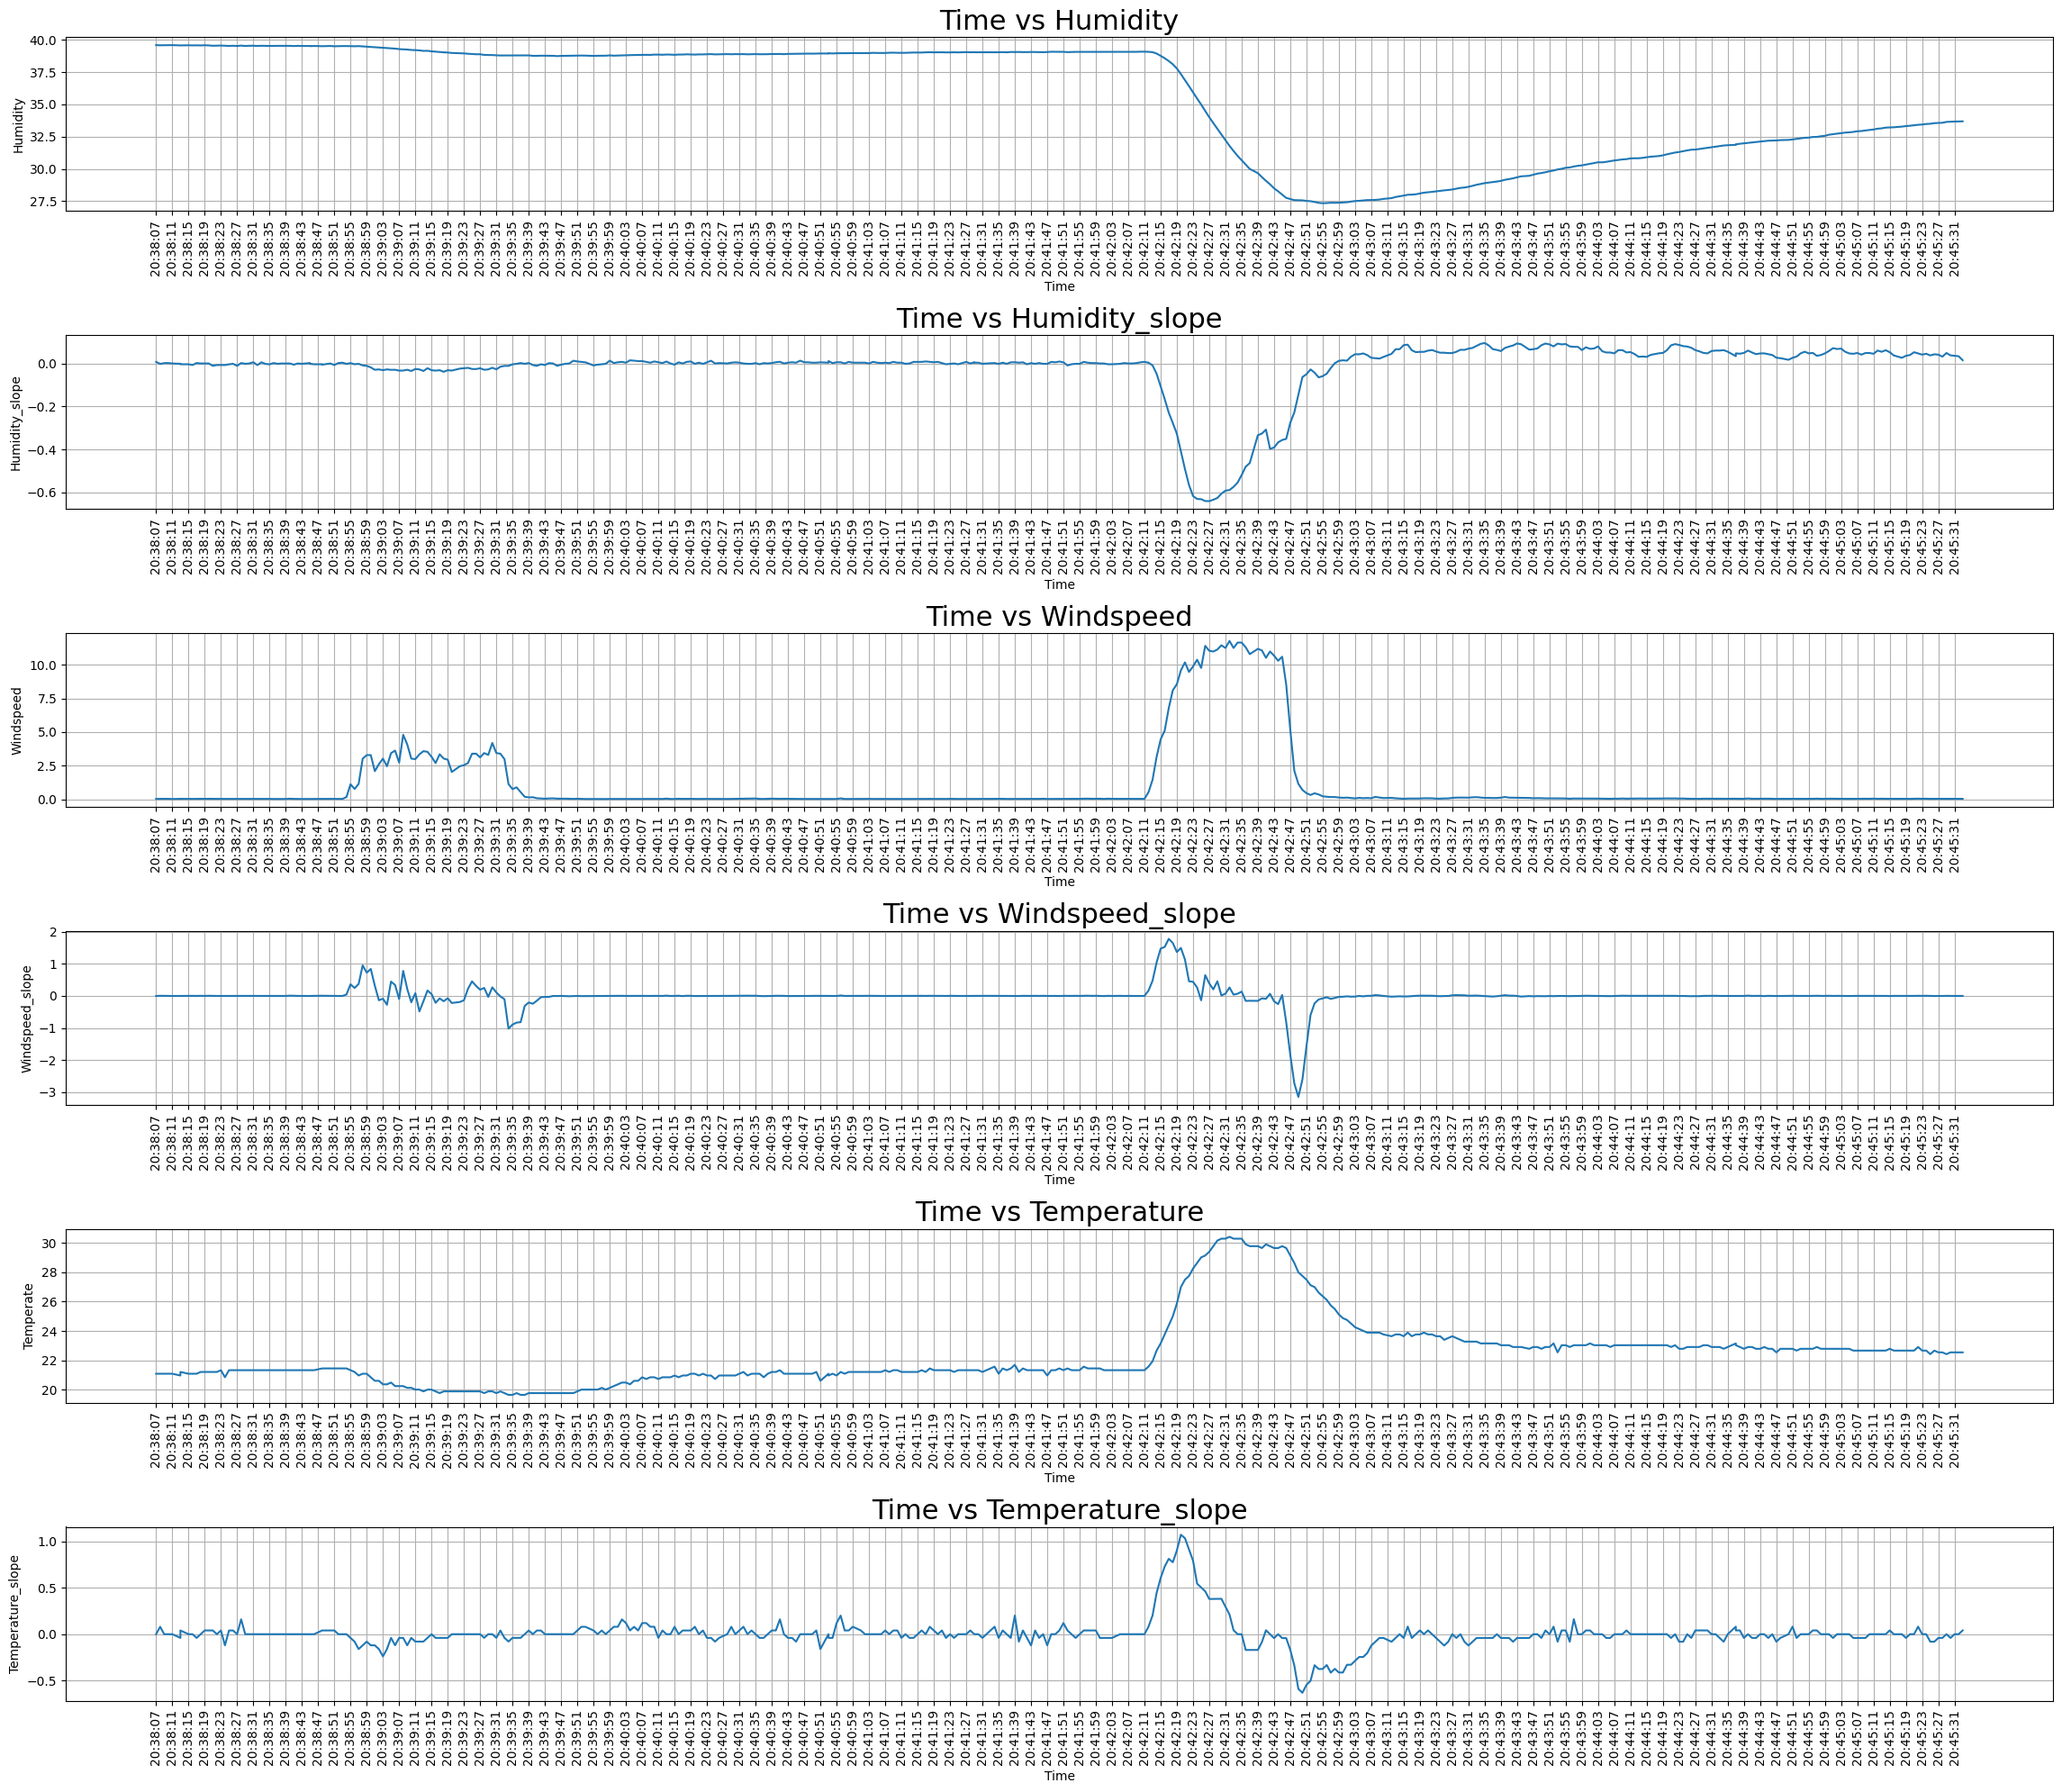

In [27]:
# First plot
df = df_new

freq='4S'
rotation = 90

df['Time'] = pd.to_datetime(df['Time'])
first_time = df.Time[0]
last_time = df.Time.iloc[-1]

plt.figure(figsize=(23, 20))
plt.subplot(6, 1, 1)  # 1 row, 2 columns, first plot
plt.plot(df.Time, df.Humidity)
plt.title('Time vs Humidity', fontsize=22)
plt.xlabel('Time')
plt.ylabel('Humidity')
xticks = pd.date_range(start=first_time, end=last_time, freq=freq)
# Extract only the time component for xticks
xticklabels = [tick.time().strftime('%H:%M:%S') for tick in xticks]
plt.xticks(xticks, labels=xticklabels, rotation=rotation)
plt.grid(True)

plt.subplot(6, 1, 2)  # 1 row, 2 columns, second plot
plt.plot(df.Time, df.Humidity_slope)
plt.title('Time vs Humidity_slope', fontsize=22)
plt.xlabel('Time')
plt.ylabel('Humidity_slope')
xticks = pd.date_range(start=first_time, end=last_time, freq=freq)
# Extract only the time component for xticks
xticklabels = [tick.time().strftime('%H:%M:%S') for tick in xticks]
plt.xticks(xticks, labels=xticklabels, rotation=rotation)
plt.grid(True)

# Second plot
plt.subplot(6, 1, 3)  # 1 row, 2 columns, second plot
plt.plot(df.Time, df.Windspeed)
plt.title('Time vs Windspeed', fontsize=22)
plt.xlabel('Time')
plt.ylabel('Windspeed')
xticks = pd.date_range(start=first_time, end=last_time, freq=freq)
# Extract only the time component for xticks
xticklabels = [tick.time().strftime('%H:%M:%S') for tick in xticks]
plt.xticks(xticks, labels=xticklabels, rotation=rotation)
plt.grid(True)

plt.subplot(6, 1, 4)  # 1 row, 2 columns, second plot
plt.plot(df.Time, df.Windspeed_slope)
plt.title('Time vs Windspeed_slope', fontsize=22)
plt.xlabel('Time')
plt.ylabel('Windspeed_slope')
xticks = pd.date_range(start=first_time, end=last_time, freq=freq)
# Extract only the time component for xticks
xticklabels = [tick.time().strftime('%H:%M:%S') for tick in xticks]
plt.xticks(xticks, labels=xticklabels, rotation=rotation)
plt.grid(True)

# Third plot
plt.subplot(6, 1, 5)  # 1 row, 2 columns, second plot
plt.plot(df.Time, df.Temperature)
plt.title('Time vs Temperature', fontsize=22)
plt.xlabel('Time')
plt.ylabel('Temperate')
xticks = pd.date_range(start=first_time, end=last_time, freq=freq)
# Extract only the time component for xticks
xticklabels = [tick.time().strftime('%H:%M:%S') for tick in xticks]
plt.xticks(xticks, labels=xticklabels, rotation=rotation)
plt.grid(True)

plt.subplot(6, 1, 6)  # 1 row, 2 columns, second plot
plt.plot(df.Time, df.Temperature_slope)
plt.title('Time vs Temperature_slope', fontsize=22)
plt.xlabel('Time')
plt.ylabel('Temperature_slope')
xticks = pd.date_range(start=first_time, end=last_time, freq=freq)
# Extract only the time component for xticks
xticklabels = [tick.time().strftime('%H:%M:%S') for tick in xticks]
plt.xticks(xticks, labels=xticklabels, rotation=rotation)
plt.grid(True)

plt.tight_layout()  # Adjusts the spacing between plots
plt.show()

In [18]:
df_new.columns

Index(['Humidity', 'Windspeed', 'Temperature', 'Date', 'Time',
       'Humidity_slope', 'Windspeed_slope', 'Temperature_slope', 'Label'],
      dtype='object')

Convert dataframe to a .csv file

In [30]:
df_new = df_new[['Date','Time','Humidity', 'Humidity_slope','Windspeed','Windspeed_slope','Temperature', \
   'Temperature_slope','Label']]
df_new.to_csv('df10.csv', index = False)